In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=9)
np.set_printoptions(suppress=True)


In [2]:
def cross_product(vec1,vec2):
    return np.cross(vec1, vec2)

def norm(vec):
    return np.linalg.norm(vec)

def get_direction_to_center(center, vec):
    return vec - center

def calc_angle(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return np.arctan(cross_prod / norm(cross_prod))

def calculate_rotation_axis(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return(cross_prod / norm(cross_prod))

def create_skew_symmetric_rotation_matrix(rot_axis):
    skew_sym_mat = np.zeros(shape=(3,3))
    x = rot_axis.item(0)
    y = rot_axis.item(1)
    z = rot_axis.item(2)
    skew_sym_mat.itemset((0,0), 0)
    skew_sym_mat.itemset((1,0), z)
    skew_sym_mat.itemset((2,0), -y)
    skew_sym_mat.itemset((0,1), -z)
    skew_sym_mat.itemset((1,1), 0)
    skew_sym_mat.itemset((2,1), x)
    skew_sym_mat.itemset((0,2), y)
    skew_sym_mat.itemset((1,2), -x)
    skew_sym_mat.itemset((0,2), 0)
    #np.array([[0, -k[2], k[1]],[k[2], 0, -k[0]],[-k[1], k[0], 0]])
    skew_sym_mat = np.array([[0, -z, y],[z, 0, -x],[-y, x, 0]])
    return skew_sym_mat
    
def create_simple_rotation_matrix(vec1, vec2):
    axis = cross_product(vec1, vec2)
    axis = axis/norm(axis)
    print(axis)
    angle = np.arccos(np.dot(norm(vec1),norm(axis)))
    print(angle)
    rot_mat = np.zeros(shape=(3,3))
    print(np.sin(angle))
    rcos = np.cos(angle)
    rsin = np.sin(angle)
    u = axis.item(0)
    v = axis.item(1)
    w = axis.item(2)
    
    rot_mat.itemset((0,0), rcos +  u * u * (1- rcos))
    rot_mat.itemset((1,0), w * rsin +  v * u * (1- rcos))
    rot_mat.itemset((2,0), -v *  rsin +  w * u * (1- rcos))
    rot_mat.itemset((0,1), -w * rsin +  u * v * (1- rcos))
    rot_mat.itemset((1,1), rcos +  v * v * (1- rcos))
    rot_mat.itemset((2,1), u * rsin +  w * v * (1- rcos))
    rot_mat.itemset((0,2), v * rsin +  u * w* (1- rcos))
    rot_mat.itemset((1,2), -u * rsin +  v * w * (1- rcos))
    rot_mat.itemset((2,2), rcos +  w * w * (1- rcos))
    
    return rot_mat

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def calculate_theta(actual_tool_direction, desired_tool_direction):
    cross = cross_product(desired_tool_direction, actual_tool_direction)
    cross_norm =norm(cross)
    dot = actual_tool_direction.dot(desired_tool_direction)
    #np.arccos(np.dot(v, vr_desired) / np.linalg.norm(v)*np.linalg.norm(vr_desired))
    #tangens = np.dot(actual_tool_direction, desired_tool_direction) / np.linalg.norm(actual_tool_direction) * np.linalg.norm(desired_tool_direction)
    #tangens = np.arccos(tangens)
    tangens = np.arctan(cross_norm/ dot)
    return tangens

def calculate_rotation_axis(actual_tool_direction, desired_tool_direction):
    cross = np.cross(actual_tool_direction, desired_tool_direction)
    cross_norm = norm(cross)
    
    return cross/cross_norm

def calculate_desired_orientattion(skew_sym_matrix, theta, actual_rot_matrix):
    identity = np.identity(3)
    first_term = identity + skew_sym_matrix * np.sin(theta) + 2 * np.multiply(skew_sym_matrix, skew_sym_matrix)
    print(first_term)
    rot_desired = np.multiply(first_term, actual_rot_matrix)
    return rot_desired
    
def get_tool_direction(troc_point, desired_point):
    return desired_point - troc_point

def look_at(center, target, up):
    f = (center - target)
    f = f/np.linalg.norm(f)
    s = np.cross(f, up)
    s = s/np.linalg.norm(s)

    u = np.cross(s, f)
    u = u/np.linalg.norm(u)

    m = np.zeros((3, 3))
    m[0] = s
    m[1] = u
    m[2] = -f

    return m

def calculate_rodriguez_formular_vector_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    vr_according_to_vector_form = current_vector *np.cos(theta) + (np.cross(rot_axis,current_vector)*np.sin(theta)) + rot_axis*(np.dot(rot_axis, current_vector))*(1.0-np.cos(theta))
    return vr_according_to_vector_form
    
def calculate_rodriguez_formular_matrix_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector,desired_vector)
    skew_sym_matrix = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + np.sin(theta) * skew_sym_matrix + (1 - np.cos(theta)) * np.matmul(skew_sym_matrix, skew_sym_matrix)
    #rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    return rot_mat
    
def calculate_desired_rotation(current_vector, desired_vector, last_rot_mat):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    skew_sym_mat = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    rot_mat = np.matmul(rot_mat, last_rot_mat)
    return rot_mat

In [38]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import proj3d
from matplotlib.pyplot import figure

import pylab

class Arrow3D(mpatches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        mpatches.FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        mpatches.FancyArrowPatch.draw(self, renderer)

#m=float(raw_input())

vector_handles=[]
used_labels=[]

def draw_vector(vec, color, label1, figure, axis):

    a = Arrow3D([vec.item(0),0],[vec.item(1),0],[vec.item(2),0],label=label1, mutation_scale=10, lw=1, arrowstyle="-|>", color=color)
    figure.patches.append(a)
    axis.add_artist(a)
    
    if label1 not in used_labels:
        used_labels.append(label1)
        vector_handles.append(a)
    
    return a

def draw_coordinate_system(coord_mat, center, figure, axis):
    x_vec = coord_mat[0]
    y_vec = coord_mat[1] 
    z_vec = coord_mat[2]
    
    x_arrow = Arrow3D([center.item(0),x_vec.item(0)],[center.item(1),x_vec.item(1)],[center.item(2),x_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="red")
    y_arrow = Arrow3D([center.item(0),y_vec.item(0)],[center.item(1),y_vec.item(1)],[center.item(2),y_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="green")
    z_arrow = Arrow3D([center.item(0),z_vec.item(0)],[center.item(1),z_vec.item(1)],[center.item(2),z_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="blue")
    figure.patches.append(x_arrow)
    axis.add_artist(x_arrow)
    figure.patches.append(y_arrow)
    axis.add_artist(y_arrow)
    figure.patches.append(z_arrow)
    axis.add_artist(z_arrow)
    
def create_points_on_circle(number, radius, height):
    number_vectors = number
    rad = 2 * np.pi / number_vectors
    radius = radius
    vectors = []

    for i in range(number_vectors):
        x = np.cos(rad * i) * radius
        y = np.sin(rad * i) * radius
        z = height
        vec = np.array([x,y,z])
        vectors.append(vec)
    return vectors

def create_points_on_line(start, end, steps):
    
    diff = end - start
    pts = []
    for i in range(steps):
        pt = start + (1.0 / steps) * i * diff
        pts.append(pt)
        
    return pts
    

def create_points_on_sphere(number, radius):
    x_vec = np.random.uniform(-1,1,number)
    y_vec = np.random.uniform(-1,1,number)
    z_vec = np.random.uniform(-1,1,number)
    vectors =[]
    for i in range(number):
        vec = np.array([x_vec[i], y_vec[i], z_vec[i]])
        vec = vec / np.linalg.norm(vec)
        vec = vec * radius
        vectors.append(vec)
    return vectors    
    
# la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
# look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))    
# draw_coordinate_system(look_at_mat, la_center,figure, axis)    
# for v in vectors:
#         draw_vector(v, "orange", "trajectory points")
def visualize_rodriguez_vector_transform(vectors, figure, axis):
    curr_vec = vectors[0]
    for v in range(1, len(vectors) - 1):
        des_vec = vectors[v]
        #print("desired vecctor = {}".format(des_vec))
        vr = calculate_rodriguez_formular_vector_form(curr_vec, des_vec)
        #print("rodriguez vector form result = {}".format(vr))
        draw_vector(vr/np.linalg.norm(vr), "purple", "calculated points", figure, axis)
        curr_vec = vr

def visualize_rodriguez_matrix_orientation(vectors, figure, axis):
    curr_vec = vectors[0]
    look_at_mat  = look_at(curr_vec,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))
    diff = []
    for v in range(1, len(vectors) ):

        des_vec = vectors[v]
        #print("desired vecctor = {}".format(des_vec))
        rot_rod = calculate_rodriguez_formular_matrix_form(curr_vec, des_vec)
        #print(rot_rod)
        vr =  np.matmul(rot_rod, curr_vec)
        la_center = vr
        #look_at_mat = np.matmul(rot_rod, np.transpose(look_at_mat))
        look_at_mat = np.matmul(look_at_mat, np.transpose(rot_rod))
        draw_coordinate_system(look_at_mat, la_center, figure, axis)
        #draw_vector(vr, "purple", "", fig, ax)
        curr_vec = vr
        diff.append(np.absolute(np.absolute(des_vec) - np.absolute(vr)))
    
    mean = np.array([0.0, 0.0, 0.0])
    
    for vec in diff:
        mean = mean + vec
        
    #print(mean / len(diff))
        

        
   
def visualize_rodriguez_advanced_matrix_orientation(vectors, figure, axis):
    la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
    look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))
    curr_vec = vectors[0]
    des_vec = vectors[1]
    rot_mat_adv = calculate_desired_rotation(curr_vec, des_vec, np.eye(3))#calculate_rodriguez_formular_matrix_form(curr_vec, vectors[1])
    curr_vec = vectors[1]
    
    diff = []
    for v in range(2, len(vectors) ):
        des_vec = vectors[v]
        rot_rod_adv = calculate_desired_rotation(curr_vec, des_vec, rot_mat_adv)
        vr = np.matmul(rot_rod_adv, curr_vec)
        curr_vec = vr
        
        la_center = vr
        #draw_vector(vr, "purple", "", fig, ax)
        look_at_mat = np.matmul(look_at_mat,np.transpose(rot_rod_adv))
        draw_coordinate_system(look_at_mat, la_center, figure, axis)
        rot_mat_adv = rot_rod_adv
        
        diff.append(np.absolute(np.absolute(des_vec) - np.absolute(vr)))
        #print(np.absolute(des_vec) - np.absolute(vr))
    #print(diff)   
    #np.mean(np.mean(data, axis=0), axis=0)
    mean = np.array([0.0, 0.0, 0.0])
    for vec in diff:
        mean = mean + vec
        
    #print(mean / len(diff))


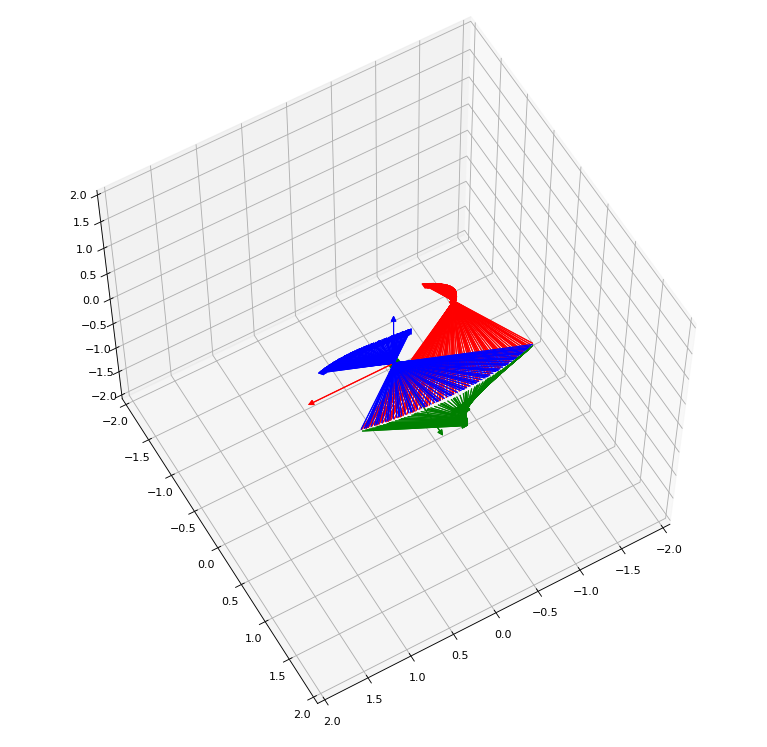

In [39]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(500, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)
# # for v in vectors:
# #     draw_vector(v, "red", "", fig, ax)
curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))

# #ax.legend(handles =vector_handles,loc='upper left')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

pts = create_points_on_line(start, end, 100)
visualize_rodriguez_advanced_matrix_orientation(pts,  fig, ax)
# for pt in pts:
#     draw_vector(pt, "purple", "", fig, ax)

# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(60, 60)
plt.show()

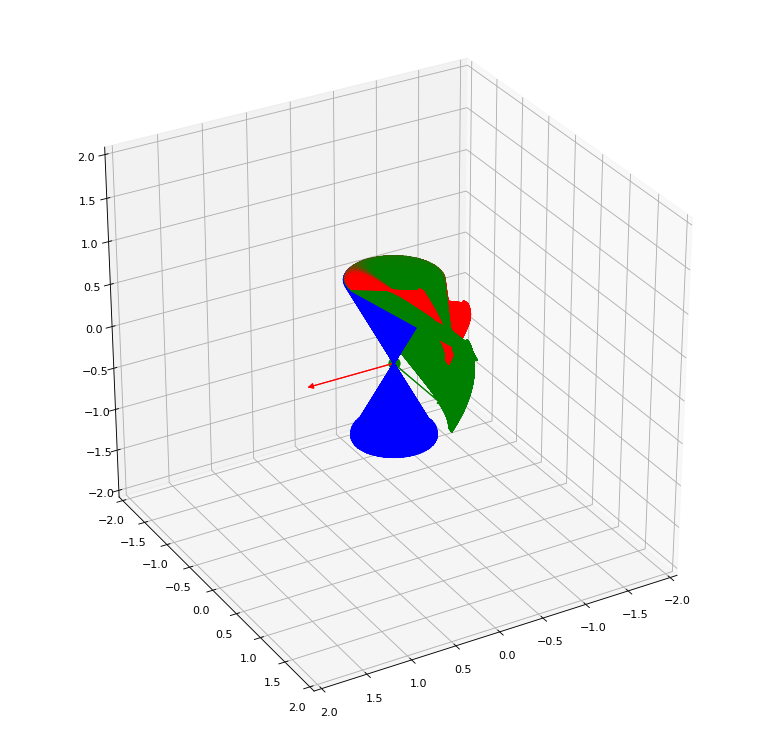

In [40]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(500, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)
# # for v in vectors:
# #     draw_vector(v, "red", "", fig, ax)
curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))

# #ax.legend(handles =vector_handles,loc='upper left')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

pts = create_points_on_circle(500, 0.50, 1.0)
visualize_rodriguez_advanced_matrix_orientation(pts,  fig, ax)
# for pt in pts:
#     draw_vector(pt, "purple", "", fig, ax)

# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(30, 60)
plt.show()

[]


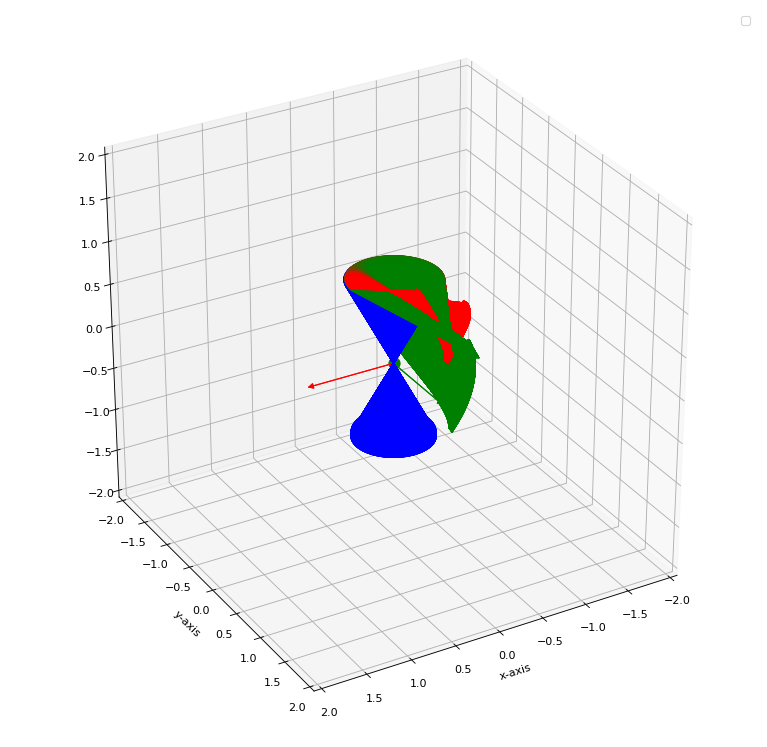

In [42]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)

draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

vectors = create_points_on_sphere(500, 1.0)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))
visualize_rodriguez_matrix_orientation(pts,  fig, ax)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(30, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

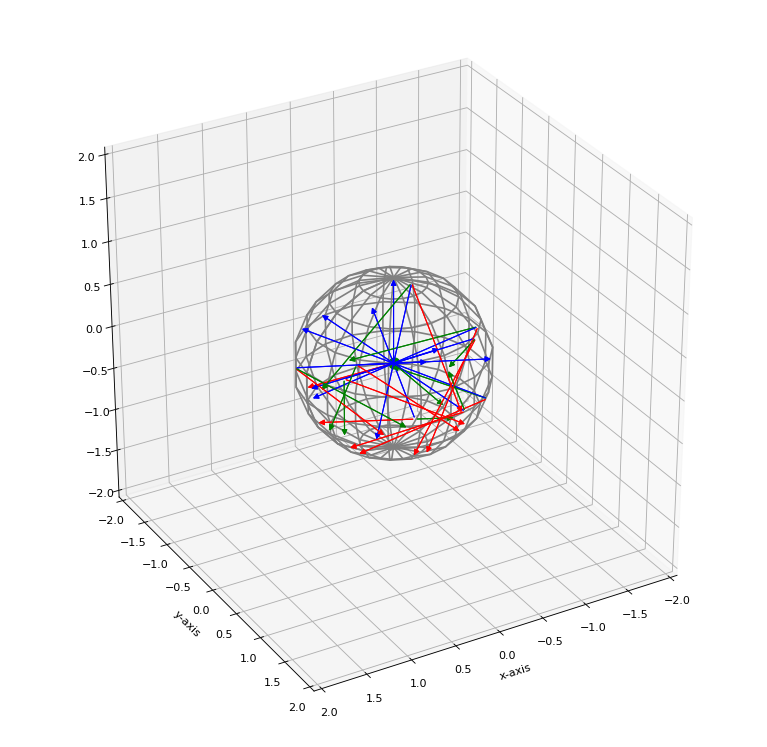

In [45]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)

draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

pts = create_points_on_sphere(10, 1.0)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))
visualize_rodriguez_matrix_orientation(pts,  fig, ax)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(30, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

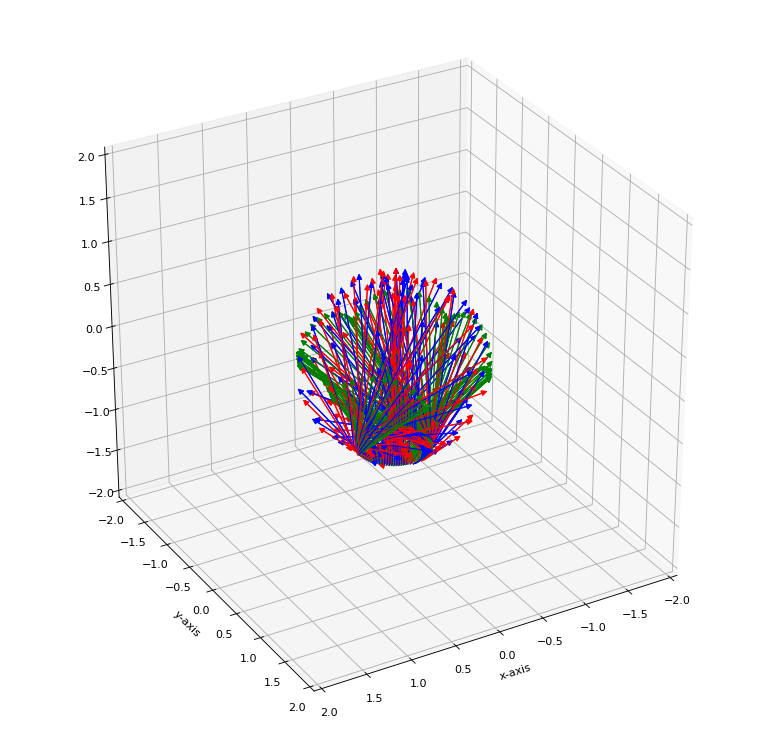

In [49]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)


number_vectors = 100
rad = 2 * np.pi / number_vectors
radius = 0.4
vectors = []


for i in range(number_vectors):
    x = np.cos(rad * i) * radius
    y = np.sin(rad * i) * radius
    z = -1.0
    vec = np.array([x,y,z])
    vectors.append(vec)

    
la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))    
draw_coordinate_system(look_at_mat, la_center, fig, ax)
                                           
for v in vectors:
    la_center = np.array([v.item(0), v.item(1), v.item(2)])
    look_at_mat = np.matmul(look_at_mat, look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0])))    
    draw_coordinate_system(look_at_mat, la_center, fig, ax)

plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.view_init(30, 60)
plt.show()

In [22]:
import ipyvolume as ipv


first_rot_axis = np.array([0.0, 1.0, 0.0])
vec1 = np.array([1.0, 1.0, 0.0])

test = cross_product(first_rot_axis, vec1)
print(test)
theta = np.arctan(norm(cross_product(first_rot_axis, vec1))/ vec1.dot(first_rot_axis))
print(theta)

# vec2 = np.array([1.5, 1.0, 0.5])
# alpha = np.arccos(vec1.item(0)/norm(vec1))/(np.pi)
# beta = np.arccos(vec1.item(1)/norm(vec1))/(np.pi)
# gamma = np.arccos(vec1.item(2)/norm(vec1))/(np.pi)
# rot_axis = cross_product(vec1, vec2)
# print(alpha)
# print(rot_axis)
# print(norm(rot_axis))

# rot_axis = rot_axis/norm(rot_axis)
# print(rot_axis)

rot_mat = rotation_matrix(first_rot_axis, theta)
print(rot_mat)

vector_rotated = rot_mat.dot(vec1)
print(vector_rotated)

[ 0.  0. -1.]
0.7853981633974483
[[ 0.707106781  0.           0.707106781]
 [ 0.           1.           0.         ]
 [-0.707106781  0.           0.707106781]]
[ 0.707106781  1.          -0.707106781]


In [23]:
x=np.array([1.0,0.5]) 
y= np.array([1.0,0.5]) 
z= np.array([1.0,0.5]) 
u= np.array([-0.6,-0.50]) 
v= np.array([0.23, -0.50]) 
w=np.array([-0.27, 0.50]) 
quiver = ipv.quickquiver(x, y, z, u, v, w, size=5)
ipv.xyzlim(-2,2)
ipv.show()

In [24]:
print(np.random.random((6, 10))*2-1)

[[ 0.704021783  0.676273079  0.358158652 -0.098533619 -0.896948606
   0.162624583  0.9185624   -0.102224804  0.109340518 -0.784926307]
 [ 0.102669694  0.077069523 -0.694981126 -0.35128022   0.929584592
  -0.040749325  0.635916189 -0.542043058  0.599092297  0.455720368]
 [ 0.102613455 -0.881653993 -0.350764691  0.925288339  0.324489299
   0.801546409 -0.856687848  0.941000303  0.085149864 -0.956555183]
 [ 0.006239058  0.928777236 -0.569700341 -0.501223474  0.438655149
  -0.392699306 -0.486476427  0.182228255  0.064374224 -0.636270626]
 [-0.35691687  -0.965124529 -0.278931674 -0.379836595  0.124656319
  -0.657876839 -0.729064215  0.810262328  0.385455909  0.845731321]
 [-0.47921983  -0.573252157 -0.590935396 -0.415755422  0.702558584
  -0.617358493 -0.678364257 -0.005668456  0.726741849 -0.143176088]]
